In [65]:
import tkinter as tk
from tkinter import filedialog
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

import json


In [121]:
# 폴더 패스 ui로 선택하기

# root = tk.Tk()
# root.withdraw()  # Tkinter 기본 창 숨기기

# folder_path = filedialog.askdirectory(title="엑셀 데이터가 있는 폴더를 선택하세요")

# if folder_path:
#     print(f"선택된 폴더: {folder_path}")
# else:
#     print("폴더 선택이 취소되었습니다.")


## 폴더 패스 직접 입력하기 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
folder_name='250718 exp#128 half half cone PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 smooth'
folder_path = os.path.join('/Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci', folder_name)


In [122]:
# 파일 경로 설정
file_name = folder_name[:14]+'_sliced_data_PT_filtered.xlsx'
file_path = os.path.join(folder_path, file_name)

# 엑셀 파일 읽기
try:
    df = pd.read_excel(file_path)
    print("엑셀 파일 불러오기 완료")
    print(df.head())
except FileNotFoundError:
    print(f"파일을 찾을 수 없습니다: {file_path}")
#대충 10초 걸림

엑셀 파일 불러오기 완료
         전압_0        전압_1        전압_2        전압_3        전압_4        전압_5  \
0  136.579187  136.594040  136.581332  136.586674  136.593028  136.580387   
1  137.489760  137.504835  137.491960  137.497458  137.503720  137.491005   
2  138.400475  138.415523  138.402658  138.408349  138.414482  138.401694   
3  139.311190  139.326317  139.313393  139.319204  139.325245  139.312313   
4  140.221905  140.237289  140.224198  140.230130  140.236043  140.223002   

         전압_6        전압_7  전압_8  전압_9  ...     전압_14       전압_15     전압_16  \
0  136.575558  136.595839     0     0  ...  1.611849  125.289280 -0.000021   
1  137.485902  137.506450     0     0  ...  1.611849  125.336135 -0.000174   
2  138.396423  138.417133     0     0  ...  1.611849  125.406417 -0.000034   
3  139.306945  139.327815     0     0  ...  1.611849  125.312708  0.000002   
4  140.217466  140.238462     0     0  ...  1.590417  125.359562 -0.000023   

      전압_17     전압_18     전압_19     전압_20     전압_21   

In [123]:
# DAQ connection 엑셀 파일명 (고정)
DAQ_connection = "DAQ connection.xlsx"
DAQ_connection_path = os.path.join(folder_path, DAQ_connection)

# DAQ connection 불러오기 (기본 첫 번째 시트)
DAQ_connection_data = pd.read_excel(DAQ_connection_path)
print(f"{DAQ_connection} 파일 불러오기 완료")
print(DAQ_connection_data.head())

DAQ connection.xlsx 파일 불러오기 완료
   # type                     PN      SN cal   a   b    etc  name
0  0    T  medtherm thermocouple  240851   E NaN NaN  model   NaN
1  1    T  medtherm thermocouple  240852   E NaN NaN  model   NaN
2  2    T  medtherm thermocouple  240853   E NaN NaN  model   NaN
3  3    T  medtherm thermocouple  240854   E NaN NaN  model   NaN
4  4    T  medtherm thermocouple  240855   E NaN NaN  model   NaN


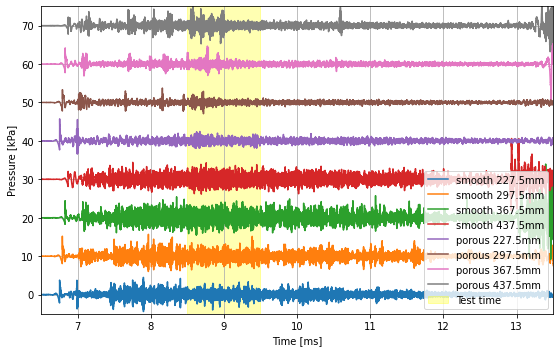

그래프 저장 완료: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/250718 exp#128 half half cone PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 smooth/Pressure_kPa_offset.pdf
데이터 파일 저장 완료: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/250718 exp#128 half half cone PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 smooth/Pressure_data_for_gnuplot_kPa_offset.dat
메타데이터 저장 완료: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/250718 exp#128 half half cone PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 smooth/Pressure_data_for_gnuplot_kPa_offset.meta.json


In [124]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

# 샘플링 주파수 [Hz]
FPS = 2.5e6
dt = 1 / FPS
num_samples = len(df)

# 시각화 범위
start_time_ms = 6.5
end_time_ms = start_time_ms+7

ymin = -5
ymax = 75  # Offset 적용 후 범위 (kPa)

# 시험 시간 범위 (ms)
that_time=7
test_start_ms = that_time + 1.5
test_end_ms = that_time + 2.5

# 시간축 생성 (-1 ms 시작)
time_axis = np.arange(num_samples) * dt - 1e-3  # [s]
time_axis_ms = time_axis * 1e3  # [ms]

# PCB 132B38 채널 찾기 (압력 센서)
pressure_rows = DAQ_connection_data[DAQ_connection_data['PN'] == 'PCB 132B38']
pressure_indices = pressure_rows['#'].values.astype(int)

# 압력 데이터를 담을 리스트
data_matrix = []
header = ["x[ms]"]

# 라벨링 설정
labels = [
    "smooth 227.5mm",
    "smooth 297.5mm",
    "smooth 367.5mm",
    "smooth 437.5mm",
    "porous 227.5mm",
    "porous 297.5mm",
    "porous 367.5mm",
    "porous 437.5mm"
]

# 그래프
plt.figure(figsize=(8, 5))
for i, idx in enumerate(pressure_indices):
    col_name = f'전압_{idx}'
    if col_name in df.columns:
        pressure_vector = df[col_name].values * 100 + i * 10  # bar → kPa 변환 및 offset
        data_matrix.append(pressure_vector)
        header.append(f"P@{labels[i]}")
        plt.plot(time_axis_ms, pressure_vector, label=labels[i])

# 시험 시간 음영
plt.axvspan(test_start_ms, test_end_ms, color='yellow', alpha=0.3, label='Test time')

# 레이블 및 축
plt.xlabel("Time [ms]")
plt.ylabel("Pressure [kPa]")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.xlim(start_time_ms, end_time_ms)
plt.ylim(ymin, ymax)

# PDF 저장
pdf_path = os.path.join(folder_path, "Pressure_kPa_offset.pdf")
plt.savefig(pdf_path, dpi=600, bbox_inches='tight')
plt.show()
print(f"그래프 저장 완료: {pdf_path}")

# DAT 파일 저장 (Gnuplot용)
dat_path = os.path.join(folder_path, "Pressure_data_for_gnuplot_kPa_offset.dat")
data_array = np.column_stack([time_axis_ms] + data_matrix)
df_export = pd.DataFrame(data_array, columns=header)
df_export.to_csv(dat_path, sep="\t", index=False, float_format="%.6f")
print(f"데이터 파일 저장 완료: {dat_path}")

# 메타데이터 딕셔너리
meta_info = {
    "xlim": [start_time_ms, end_time_ms],
    "ylim": [ymin, ymax],
    "xlabel": "Time [ms]",
    "ylabel": "Pressure [kPa]",
    "shaded_region": [test_start_ms, test_end_ms],
    "sensors": labels,
    "offset_step_kPa": 10
}

# 메타 파일 저장
meta_path = os.path.join(folder_path, "Pressure_data_for_gnuplot_kPa_offset.meta.json")
with open(meta_path, "w") as f:
    json.dump(meta_info, f, indent=4)

print(f"메타데이터 저장 완료: {meta_path}")


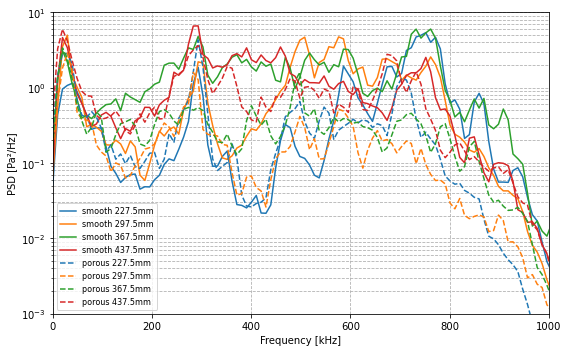

PSD 그래프 저장 완료: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/250718 exp#128 half half cone PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 smooth/Pressure_PSD_Welch.pdf
PSD 데이터 저장 완료: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/250718 exp#128 half half cone PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 smooth/Pressure_PSD_Welch.dat


In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import os

# =====================
# 시험 구간 데이터 추출
# =====================
mask = (time_axis_ms >= test_start_ms) & (time_axis_ms <= test_end_ms)

# Welch 파라미터
nperseg = 2**8  # 256 포인트
noverlap = nperseg // 2

# 센서 라벨 및 위치 그룹
positions = [227.5, 297.5, 367.5, 437.5]
labels = [
    "smooth 227.5mm",
    "smooth 297.5mm",
    "smooth 367.5mm",
    "smooth 437.5mm",
    "porous 227.5mm",
    "porous 297.5mm",
    "porous 367.5mm",
    "porous 437.5mm"
]

# 위치별 색상 지정 (4개)
colors = {
    227.5: 'tab:blue',
    297.5: 'tab:orange',
    367.5: 'tab:green',
    437.5: 'tab:red'
}

# =====================
# PSD 계산
# =====================
plt.figure(figsize=(8, 5))
for i, idx in enumerate(pressure_indices):
    col_name = f'전압_{idx}'
    if col_name not in df.columns:
        continue

    # bar -> Pa 변환
    pressure_Pa = df[col_name].values[mask] * 1e5

    # Welch PSD
    freqs, psd = welch(pressure_Pa, fs=FPS, nperseg=nperseg, noverlap=noverlap)

    # 포러스는 점선, 스무스는 실선
    linestyle = '--' if i >= 4 else '-'

    # 위치에 맞는 색상
    pos = positions[i % 4]  # 0~3번 위치를 순환
    color = colors[pos]

    # PSD plot
    plt.semilogy(freqs/1000, psd, linestyle=linestyle, color=color, label=labels[i])

plt.xlabel("Frequency [kHz]")
plt.ylabel("PSD [Pa²/Hz]")
plt.legend(loc='lower left', fontsize=8)
plt.grid(True, which='both', ls='--')
plt.xlim(0, 1000)
plt.ylim(10**-3, 10**1)  # 필요 시 조정
plt.tight_layout()

# PDF 저장
psd_pdf_path = os.path.join(folder_path, "Pressure_PSD_Welch.pdf")
plt.savefig(psd_pdf_path, dpi=600, bbox_inches='tight')
plt.show()
print(f"PSD 그래프 저장 완료: {psd_pdf_path}")

# =====================
# PSD 데이터 저장
# =====================
psd_data = pd.DataFrame({"f[kHz]": freqs/1000})
for i, idx in enumerate(pressure_indices):
    col_name = f'전압_{idx}'
    if col_name in df.columns:
        pressure_Pa = df[col_name].values[mask] * 1e5
        _, psd = welch(pressure_Pa, fs=FPS, nperseg=nperseg, noverlap=noverlap)
        psd_data[labels[i]] = psd

psd_dat_path = os.path.join(folder_path, "Pressure_PSD_Welch.dat")
psd_data.to_csv(psd_dat_path, sep="\t", index=False, float_format="%.6e")
print(f"PSD 데이터 저장 완료: {psd_dat_path}")


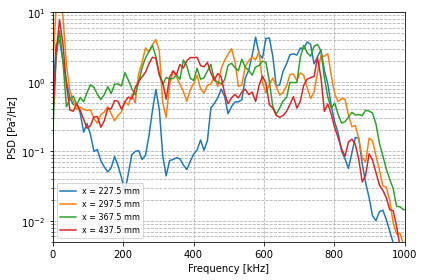

Smooth PSD 그래프 저장 완료: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/250725 exp#134 half half cone2 PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 porous/Pressure_PSD_Welch_Smooth.pdf


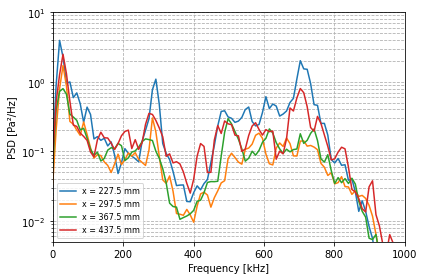

Porous non-uniform PSD 그래프 저장 완료: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/250725 exp#134 half half cone2 PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 porous/Pressure_PSD_Welch_PorousUniform.pdf
PSD 데이터 저장 완료: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/250725 exp#134 half half cone2 PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 porous/Pressure_PSD_Welch.dat


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import os
import pandas as pd

# =====================
# 시험 구간 데이터 추출
# =====================
mask = (time_axis_ms >= test_start_ms) & (time_axis_ms <= test_end_ms)

# Welch 파라미터
nperseg = 2**8
noverlap = nperseg // 2

# 위치 및 색상
positions = [227.5, 297.5, 367.5, 437.5]
colors = {
    227.5: 'tab:blue',
    297.5: 'tab:orange',
    367.5: 'tab:green',
    437.5: 'tab:red'
}

# 라벨
labels = [
    "x = 227.5 mm",
    "x = 297.5 mm",
    "x = 367.5 mm",
    "x = 437.5 mm",
    "x = 227.5 mm",   # ← 수정됨
    "x = 297.5 mm",
    "x = 367.5 mm",
    "x = 437.5 mm"
]

# =====================
# PSD 계산 및 별도 시각화
# =====================

# 1. Smooth
plt.figure(figsize=(6, 4))
for i in range(4):
    idx = pressure_indices[i]
    col_name = f'전압_{idx}'
    if col_name not in df.columns:
        continue

    pressure_Pa = df[col_name].values[mask] * 1e5
    freqs, psd = welch(pressure_Pa, fs=FPS, nperseg=nperseg, noverlap=noverlap)
    pos = positions[i]
    color = colors[pos]

    plt.semilogy(freqs / 1000, psd, linestyle='-', color=color, label=labels[i])

# plt.title("Smooth")
plt.xlabel("Frequency [kHz]")
plt.ylabel("PSD [Pa²/Hz]")
plt.xlim(0, 1000)
plt.ylim(5e-3, 1e1)
plt.grid(True, which='both', ls='--')
plt.legend(fontsize=8, loc='lower left')
plt.tight_layout()

smooth_pdf_path = os.path.join(folder_path, "Pressure_PSD_Welch_Smooth.pdf")
plt.savefig(smooth_pdf_path, dpi=600, bbox_inches='tight')
plt.show()
print(f"Smooth PSD 그래프 저장 완료: {smooth_pdf_path}")

# 2. Porous non-uniform
plt.figure(figsize=(6, 4))
for i in range(4, 8):
    idx = pressure_indices[i]
    col_name = f'전압_{idx}'
    if col_name not in df.columns:
        continue

    pressure_Pa = df[col_name].values[mask] * 1e5
    freqs, psd = welch(pressure_Pa, fs=FPS, nperseg=nperseg, noverlap=noverlap)
    pos = positions[i % 4]
    color = colors[pos]

    plt.semilogy(freqs / 1000, psd, linestyle='-', color=color, label=labels[i])

# plt.title("Porous non-uniform")
plt.xlabel("Frequency [kHz]")
plt.ylabel("PSD [Pa²/Hz]")
plt.xlim(0, 1000)
plt.ylim(5e-3, 1e1)
plt.grid(True, which='both', ls='--')
plt.legend(fontsize=8, loc='lower left')
plt.tight_layout()

porous_pdf_path = os.path.join(folder_path, "Pressure_PSD_Welch_PorousUniform.pdf")
plt.savefig(porous_pdf_path, dpi=600, bbox_inches='tight')
plt.show()
print(f"Porous non-uniform PSD 그래프 저장 완료: {porous_pdf_path}")




In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Base path
base_path = "/Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci"

# PSD 파일 경로
file_128 = os.path.join(base_path, "250718 exp#128 half half cone PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 smooth", "Pressure_PSD_Welch.dat")
file_134 = os.path.join(base_path, "250725 exp#134 half half cone2 PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 porous", "Pressure_PSD_Welch.dat")

# Load both
df_128 = pd.read_csv(file_128, sep="\t")
df_134 = pd.read_csv(file_134, sep="\t")

# Frequency
freq_kHz = df_128["f[kHz]"]

# 위치들
positions = [227.5, 297.5, 367.5, 437.5]

# 색상 맵핑
color_map = {
    "Smooth": "red",
    "Porous (uniform)": "blue",
    "Porous (non-uniform Ⅱ)": "green"
}

# 시각화
for i, pos in enumerate(positions):
    plt.figure(figsize=(6, 4))

    # Smooth (128번, 센서 0~3)
    col_smooth = [col for col in df_128.columns if f"{pos}" in col][0]
    plt.semilogy(freq_kHz, df_128[col_smooth], label="Smooth", color=color_map["Smooth"], linestyle='-')

    # Porous uniform (128번, 센서 4~7)
    col_uniform = [col for col in df_128.columns[5:] if f"{pos}" in col]
    if col_uniform:
        plt.semilogy(freq_kHz, df_128[col_uniform[0]], label="Uniform porous", color=color_map["Porous (uniform)"], linestyle='-')

    # Porous non-uniform (134번, 센서 4~7)
    col_nonuniform = [col for col in df_134.columns[5:] if f"{pos}" in col]
    if col_nonuniform:
        plt.semilogy(freq_kHz, df_134[col_nonuniform[0]], label="Non-uniform porous", color=color_map["Porous (non-uniform Ⅱ)"], linestyle='-')

    # Plot settings
    plt.title(f"x = {pos} mm")
    plt.xlabel("Frequency [kHz]")
    plt.ylabel("PSD [Pa²/Hz]")
    plt.xlim(0, 1000)
    plt.ylim(1e-2, 5e1)  # 변경된 y축 범위
    plt.grid(True, which='both', linestyle='--')
    plt.legend(loc='upper right')
    plt.tight_layout()

    save_name = f"PSD_Comparison_x_{int(pos)}mm.pdf"
    save_path = os.path.join(base_path, save_name)
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.close()

    print(f"✅ 저장 완료: {save_name}")


✅ 저장 완료: PSD_Comparison_x_227mm.pdf
✅ 저장 완료: PSD_Comparison_x_297mm.pdf
✅ 저장 완료: PSD_Comparison_x_367mm.pdf
✅ 저장 완료: PSD_Comparison_x_437mm.pdf


In [115]:
print("df_128 columns:")
print(df_128.columns)

print("\ndf_134 columns:")
print(df_134.columns)


df_128 columns:
Index(['f[kHz]', 'x = 227.5 mm', 'x = 297.5 mm', 'x = 367.5 mm',
       'x = 437.5 mm'],
      dtype='object')

df_134 columns:
Index(['f[kHz]', 'x = 227.5 mm', 'x = 297.5 mm', 'x = 367.5 mm',
       'x = 437.5 mm'],
      dtype='object')


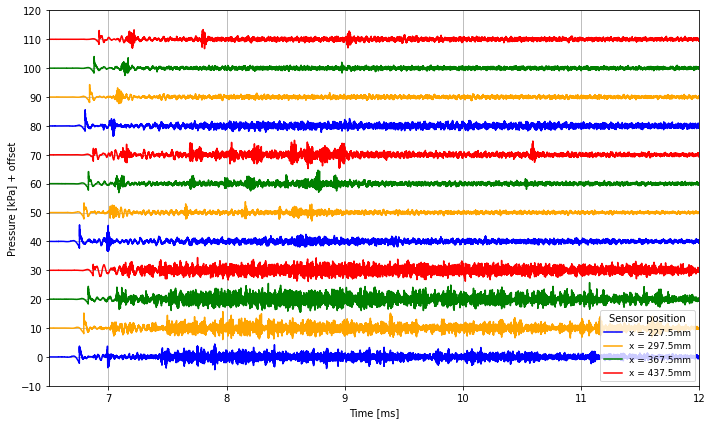

그래프 저장 완료: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/Pressure_Combined_128_134_FINAL_clipped_legend_by_position.pdf


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 실험 폴더 및 정보 정의
base_path = '/Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci'

experiment_configs = [
    {
        'folder': '250718 exp#128 half half cone PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 smooth',
        'label_prefix': ['Smooth', 'Porous Uniform'],
        'time_range': (6.5, 12.0),
        'x_shift_ms': 0.0
    },
    {
        'folder': '250725 exp#134 half half cone2 PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 porous',
        'label_prefix': ['Porous Non-uniform'],
        'time_range': (6.5, 12.0),
        'x_shift_ms': -1.6  # 수정됨
    }
]

# 시각화 설정
plt.figure(figsize=(10, 6))
offset_step = + 10  # 아래로 정렬
FPS = 2.5e6
dt = 1 / FPS

color_cycle = ['blue','orange', 'green',  'red']
z_positions = [227.5, 297.5, 367.5, 437.5]
offset_idx = 0

legend_labels_added = set()

for config in experiment_configs:
    folder_path = os.path.join(base_path, config['folder'])

    # 파일 경로 탐색
    xlsx_file = [f for f in os.listdir(folder_path) if f.endswith("_sliced_data_PT_filtered.xlsx")][0]
    dat_path = os.path.join(folder_path, xlsx_file)
    daq_path = os.path.join(folder_path, "DAQ connection.xlsx")

    # 데이터 불러오기
    df = pd.read_excel(dat_path)
    daq_df = pd.read_excel(daq_path)

    # 압력 채널 처리
    if 'exp#134' in config['folder']:
        pressure_indices = [20, 21, 22, 23]
    else:
        pressure_rows = daq_df[daq_df['PN'] == 'PCB 132B38']
        pressure_indices = pressure_rows['#'].values.astype(int)

    # 시간축 계산 및 평행이동
    num_samples = len(df)
    time_axis = np.arange(num_samples) * dt - 1e-3
    time_axis_ms = time_axis * 1e3 + config['x_shift_ms']

    start_ms, end_ms = config['time_range']
    time_mask = (time_axis_ms >= start_ms) & (time_axis_ms <= end_ms)

    label_group = config['label_prefix']

    for group_idx, group in enumerate(label_group):
        for i in range(4):
            col_idx = group_idx * 4 + i if 'exp#134' not in config['folder'] else i
            if col_idx >= len(pressure_indices):
                continue
            sensor_num = pressure_indices[col_idx]
            col_name = f'전압_{sensor_num}'
            z_pos = z_positions[i]
            if col_name in df.columns:
                signal = df[col_name].values * 100 + offset_idx * offset_step
                # 위치 기반 레이블 (중복 방지)
                base_label = f"x = {z_pos}mm"
                label = base_label if base_label not in legend_labels_added else None
                color = color_cycle[i % len(color_cycle)]
                plt.plot(time_axis_ms[time_mask], signal[time_mask],
                         label=label, color=color)
                if label:
                    legend_labels_added.add(base_label)
                offset_idx += 1

# 그래프 설정
plt.xlabel("Time [ms]")
plt.ylabel("Pressure [kPa] + offset")
plt.grid(True)
plt.xlim(6.5, 12.0)
plt.ylim(-10, 120)
plt.yticks([-10 +10 * i for i in range(14)])

plt.legend(loc='lower right', fontsize=9, title="Sensor position")
plt.tight_layout()

# 저장
save_path = os.path.join(base_path, "Pressure_Combined_128_134_FINAL_clipped_legend_by_position.pdf")
plt.savefig(save_path, dpi=600, bbox_inches='tight')
plt.show()
print(f"그래프 저장 완료: {save_path}")


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== Paths & configs =====
base_path = '/Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci'

experiment_configs = [
    {
        'folder': '250718 exp#128 half half cone PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 smooth',
        'label_prefix': ['Smooth', 'Porous Uniform'],
        'time_range': (6.5, 11.0),
        'x_shift_ms': 0.0
    },
    {
        'folder': '250725 exp#134 half half cone2 PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 porous',
        'label_prefix': ['Porous Non-uniform'],
        'time_range': (6.5, 11.0),
        'x_shift_ms': -1.6
    }
]

# ===== Plot style =====
offset_step = 10      # vertical offset per trace
FPS = 2.5e6
dt = 1 / FPS
color_cycle = ['blue', 'orange', 'green', 'red']
z_positions = [227.5, 297.5, 367.5, 437.5]

# 각 그룹별 figure를 보관
figs = {}  # key: group label, val: dict(fig, ax, legend_set, offset_idx, time_range)

def _slug(s):
    return (s.lower()
              .replace(' ', '_')
              .replace('-', '_')
              .replace('(', '')
              .replace(')', ''))

# ===== Main loop =====
for config in experiment_configs:
    folder_path = os.path.join(base_path, config['folder'])

    # 파일 찾기
    xlsx_file = [f for f in os.listdir(folder_path) if f.endswith("_sliced_data_PT_filtered.xlsx")][0]
    dat_path = os.path.join(folder_path, xlsx_file)
    daq_path = os.path.join(folder_path, "DAQ connection.xlsx")

    # 데이터 로드
    df = pd.read_excel(dat_path)
    daq_df = pd.read_excel(daq_path)

    # 압력 채널 index
    if 'exp#134' in config['folder']:
        pressure_indices = [20, 21, 22, 23]
    else:
        pressure_rows = daq_df[daq_df['PN'] == 'PCB 132B38']
        pressure_indices = pressure_rows['#'].values.astype(int)

    # 시간축 (ms) + 실험별 shift
    num_samples = len(df)
    time_axis = np.arange(num_samples) * dt - 1e-3
    time_axis_ms = time_axis * 1e3 + config['x_shift_ms']
    t0, t1 = config['time_range']
    time_mask = (time_axis_ms >= t0) & (time_axis_ms <= t1)

    # 이 폴더에 포함된 각 그룹 처리
    for group_idx, group_label in enumerate(config['label_prefix']):
        # 그룹별 figure 초기화(최초 1회)
        if group_label not in figs:
            fig, ax = plt.subplots(figsize=(6, 4))
            figs[group_label] = {
                'fig': fig,
                'ax': ax,
                'legend_set': set(),
                'offset_idx': 0,
                'time_range': config['time_range']  # 그룹마다 다른 time_range일 수 있음
            }

        ax = figs[group_label]['ax']

        # 해당 그룹의 4개 센서 플롯
        for i in range(4):
            col_idx = i if 'exp#134' in config['folder'] else (group_idx * 4 + i)
            if col_idx >= len(pressure_indices):
                continue

            sensor_num = pressure_indices[col_idx]
            col_name = f'전압_{sensor_num}'
            if col_name not in df.columns:
                continue

            z_pos = z_positions[i]
            signal = df[col_name].values * 100 + figs[group_label]['offset_idx'] * offset_step  # kPa로 가정(+offset)

            base_label = f"x = {z_pos}mm"
            label = base_label if base_label not in figs[group_label]['legend_set'] else None
            color = color_cycle[i % len(color_cycle)]

            ax.plot(time_axis_ms[time_mask], signal[time_mask], label=label, color=color)
            if label:
                figs[group_label]['legend_set'].add(base_label)
            figs[group_label]['offset_idx'] += 1

# ===== Finalize & save per group =====
for group_label, st in figs.items():
    ax = st['ax']
    # 축/격자/범례
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Pressure [kPa] + offset")
    ax.grid(True)
    ax.set_xlim(*st['time_range'])

    # y-축은 트레이스 개수에 맞춰 자동으로 약간 넉넉히 설정
    n_traces = st['offset_idx']
    ymax = max(30, offset_step * n_traces)
    ax.set_ylim(-10, ymax)
    ytick_end = int(np.ceil(ymax / 10.0) * 10)
    ax.set_yticks(list(range(-10, ytick_end + 1, 10)))

    ax.legend(loc='lower right', fontsize=9)
    st['fig'].tight_layout()

    # 저장
    fname = f"Pressure_{_slug(group_label)}.pdf"
    save_path = os.path.join(base_path, fname)
    st['fig'].savefig(save_path, dpi=600, bbox_inches='tight')
    print(f"[Saved] {group_label}: {save_path}")

plt.close('all')


[Saved] Smooth: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/Pressure_smooth.pdf
[Saved] Porous Uniform: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/Pressure_porous_uniform.pdf
[Saved] Porous Non-uniform: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/Pressure_porous_non_uniform.pdf


In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== Paths & configs =====
base_path = '/Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci'

experiment_configs = [
    {
        'folder': '250718 exp#128 half half cone PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 smooth',
        'label_prefix': ['Smooth', 'Porous Uniform'],
        'time_range': (8.8, 9.0),
        'x_shift_ms': 0.0
    },
    {
        'folder': '250725 exp#134 half half cone2 PET150 x23 driven 0.2barg He M6.8 2.5MHz FL200x2 porous',
        'label_prefix': ['Porous Non-uniform'],
        'time_range': (8.8, 9.0),
        'x_shift_ms': -1.6
    }
]

# ===== Plot style =====
offset_step = 10      # vertical offset per trace
FPS = 2.5e6
dt = 1 / FPS
color_cycle = ['blue', 'orange', 'green', 'red']
z_positions = [227.5, 297.5, 367.5, 437.5]

# 각 그룹별 figure를 보관
figs = {}  # key: group label, val: dict(fig, ax, legend_set, offset_idx, time_range)

def _slug(s):
    return (s.lower()
              .replace(' ', '_')
              .replace('-', '_')
              .replace('(', '')
              .replace(')', ''))

# ===== Main loop =====
for config in experiment_configs:
    folder_path = os.path.join(base_path, config['folder'])

    # 파일 찾기
    xlsx_file = [f for f in os.listdir(folder_path) if f.endswith("_sliced_data_PT_filtered.xlsx")][0]
    dat_path = os.path.join(folder_path, xlsx_file)
    daq_path = os.path.join(folder_path, "DAQ connection.xlsx")

    # 데이터 로드
    df = pd.read_excel(dat_path)
    daq_df = pd.read_excel(daq_path)

    # 압력 채널 index
    if 'exp#134' in config['folder']:
        pressure_indices = [20, 21, 22, 23]
    else:
        pressure_rows = daq_df[daq_df['PN'] == 'PCB 132B38']
        pressure_indices = pressure_rows['#'].values.astype(int)

    # 시간축 (ms) + 실험별 shift
    num_samples = len(df)
    time_axis = np.arange(num_samples) * dt - 1e-3
    time_axis_ms = time_axis * 1e3 + config['x_shift_ms']
    t0, t1 = config['time_range']
    time_mask = (time_axis_ms >= t0) & (time_axis_ms <= t1)

    # 이 폴더에 포함된 각 그룹 처리
    for group_idx, group_label in enumerate(config['label_prefix']):
        # 그룹별 figure 초기화(최초 1회)
        if group_label not in figs:
            fig, ax = plt.subplots(figsize=(6, 3))
            figs[group_label] = {
                'fig': fig,
                'ax': ax,
                'legend_set': set(),
                'offset_idx': 0,
                'time_range': config['time_range']  # 그룹마다 다른 time_range일 수 있음
            }

        ax = figs[group_label]['ax']

        # 해당 그룹의 4개 센서 플롯
        for i in range(4):
            col_idx = i if 'exp#134' in config['folder'] else (group_idx * 4 + i)
            if col_idx >= len(pressure_indices):
                continue

            sensor_num = pressure_indices[col_idx]
            col_name = f'전압_{sensor_num}'
            if col_name not in df.columns:
                continue

            z_pos = z_positions[i]
            signal = df[col_name].values * 100 + figs[group_label]['offset_idx'] * offset_step  # kPa로 가정(+offset)

            base_label = f"x = {z_pos}mm"
            label = base_label if base_label not in figs[group_label]['legend_set'] else None
            color = color_cycle[i % len(color_cycle)]

            ax.plot(time_axis_ms[time_mask], signal[time_mask], label=label, color=color)
            if label:
                figs[group_label]['legend_set'].add(base_label)
            figs[group_label]['offset_idx'] += 1

# ===== Finalize & save per group =====
for group_label, st in figs.items():
    ax = st['ax']
    # 축/격자/범례
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Pressure [kPa] + offset")
    ax.grid(True)
    ax.set_xlim(*st['time_range'])

    # y-축은 트레이스 개수에 맞춰 자동으로 약간 넉넉히 설정
    n_traces = st['offset_idx']
    ymax = max(30, offset_step * n_traces)
    ax.set_ylim(-10, ymax)
    ytick_end = int(np.ceil(ymax / 10.0) * 10)
    ax.set_yticks(list(range(-10, ytick_end + 1, 10)))

    ax.legend(loc='upper right', fontsize=9)
    st['fig'].tight_layout()

    # 저장
    fname = f"Pressure_{_slug(group_label)}.pdf"
    save_path = os.path.join(base_path, fname)
    st['fig'].savefig(save_path, dpi=600, bbox_inches='tight')
    print(f"[Saved] {group_label}: {save_path}")

plt.close('all')


[Saved] Smooth: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/Pressure_smooth.pdf
[Saved] Porous Uniform: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/Pressure_porous_uniform.pdf
[Saved] Porous Non-uniform: /Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/Pressure_porous_non_uniform.pdf
